# 囚徒困境演化博弈分析
姓名：邹子涵  
学号：202020085400139

<p style="text-indent:2em"></p>

## 一、囚徒困境

<p style="text-indent:2em">囚徒困境（prisoner's dilemma）是指两个被捕的囚徒之间的一种特殊博弈，说明为什么甚至在合作对双方都有利时，保持合作也是困难的。囚徒困境是博弈论的非零和博弈中具代表性的例子，反映个人最佳选择并非团体最佳选择。虽然困境本身只属模型性质，但现实中的价格竞争、环境保护、人际关系等方面，也会频繁出现类似情况。</p>

### 1.1、理论起源
<p style="text-indent:2em">囚徒困境的故事讲的是，两个嫌疑犯作案后被警察抓住，分别关在不同的屋子里接受审讯。警察知道两人有罪，但缺乏足够的证据。警察告诉每个人：如果两人都抵赖，各判刑一年；如果两人都坦白，各判八年；如果两人中一个坦白而另一个抵赖，坦白的放出去，抵赖的判十年。于是，每个囚徒都面临两种选择：坦白或抵赖。然而，不管同伙选择什么，每个囚徒的最优选择是坦白：如果同伙抵赖、自己坦白的话放出去，抵赖的话判十年，坦白比不坦白好；如果同伙坦白、自己坦白的话判八年，比起抵赖的判十年，坦白还是比抵赖的好。</p>

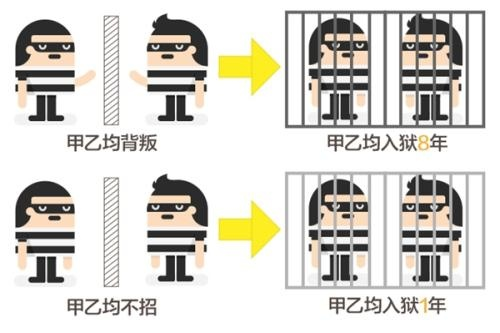

<p style="text-indent:2em">结果，两个嫌疑犯都选择坦白，各判刑八年。如果两人都抵赖，各判一年，显然这个结果好。囚徒困境所反映出的深刻问题是，人类的个人理性有时能导致集体的非理性--聪明的人类会因自己的聪明而作茧自缚，或者损害集体的利益。</p>

## 二、python实现沙盒模式下囚徒困境演化过程

### 2.1、过程构思
在沙盒模式下，初始化数个拥有不同策略、初始个数相同的人群，使他们在沙盒中随机进行博弈数轮，每轮结束后淘汰一定比例得分较低的人数，并在博弈过程中加入随机变异。

### 2.2、代码解读

#### 2.2.1、导包并初始化囚徒选择
将BETRAY（背叛）定义为False  
COOPERATE（合作）定义为True

In [1]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import sys
import inspect

BETRAY = True
COOPERATE = False

工具函数takeSecond(elem)，用于获取列表的第二个元素

In [2]:
def takeSecond(elem):
    return elem[1]

#### 2.2.2、定义策略母类
在策略母类中定义了以下几个方法：

+ get_score:得分方法，当自身得分长度大于50时。将得分进行累加
+ __init__：初始化方法，包含三个参数：my_history/theirhistory/score，分别用来记录自身最后的选择、上一博弈对手的选择以及得分情况
+ play：博弈方法
+ reinit_history：重新初始化，重置自身最后的选择和上一博弈对手的选择

In [3]:
class Alg:

    def get_score(self):
        if len(self.score)>50:
            self.score = [sum(self.score)]
        return self.score

    def __init__(self):
        self.my_history = []
        self.their_history = []
        self.score = []

    def play(self):
        raise NotImplementedError

    def __repr__(self):
        return "{}".format(type(self).__name__)

    def reinit_history(self):
        self.my_history = []
        self.their_history = []
        return self

#### 2.2.3、定义分组方法
该方法的目标是将列表ls中的人群按照size大小进行切分分组。

In [4]:
def partition(ls, size):
    return [ls[i:i + size] for i in range(0, len(ls), size)]

测试案例：

In [5]:
# list = partition([1,2,3,4,5,6,7,8,9,1],3)
# print(list)

#### 2.2.4、定义囚徒困境的收益矩阵
这里通过将囚徒困境的收益矩阵给改为正值，方便计算并比较得分情况，更改后的囚徒困境收益矩阵为下图所示：

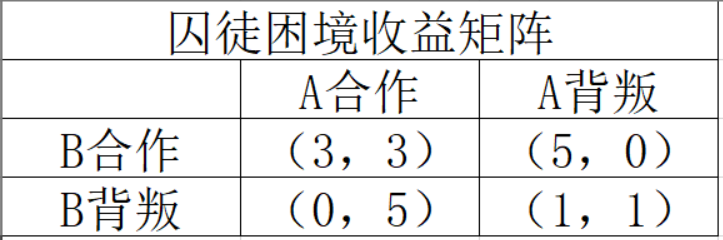

In [6]:
def score(A_choice, B_choice):
    if A_choice == B_choice:
        if A_choice == BETRAY:
            return (1, 1)
        return (3, 3)
    if A_choice == BETRAY:
        return (5, 0)
    return (0, 5)

#### 2.2.5、定义博弈过程
A与B博弈，将自己的选择记录在my_history中，将对方的选择记录在their_history中，并将A、B的得分记录在score中。

In [7]:
def play(A, B):
    A_score = 0
    B_score = 0
    A_choice = A.play(A.my_history, B.my_history)
    B_choice = B.play(B.my_history, A.my_history)
    A_score_, B_score_ = score(A_choice, B_choice)
    A.my_history.append(A_choice)
    B.my_history.append(B_choice)
    A.their_history.append(B_choice)
    B.their_history.append(A_choice)
    A.score.append(A_score_)
    B.score.append(B_score_)
    return (A_score_, B_score_)

#### 2.2.6、定义沙盒模式
在沙盒模式中会将所有人进行两两分组————partition(persons, 2)，persons为参与博弈的所有人群对象，rounds为博弈轮数。  
在每一轮中，对分好组的两人进行一次博弈

In [8]:
# 一期博弈过程，即所有样本随机两两匹配后博弈rounds次
def simulate(persons, rounds, seed=0):
    random.shuffle(persons)
    persons_pairs = partition(persons, 2)
    for i in range(rounds):
        for pair in persons_pairs:
            play(pair[0], pair[1])

#### 2.2.7、沙盒世界更新
在每轮博弈完成后，会对沙盒世界中的人群对象进行更新，包括策略变更、淘汰和生成新的样本（新加入的玩家）

In [9]:
def self_reproduction(persons, mutation_rate, out_rate):
#     按照变异比率获取当前人数中变更策略的对象数量
    mutation_count = int(len(persons) * mutation_rate)
#     按照淘汰比率获取当前人数中被淘汰的对象数量
    out_count = int(len(persons) * out_rate)
    for person in persons:
        score_list = [sum(person.get_score()) for person in persons]
#     将人群按照得分顺序进行排列
    persons.sort(key=lambda x: sum(x.get_score()), reverse=True)
    score_sorted = [sum(person.get_score()) for person in persons]
#     获取淘汰样本及变异样本
    out_persons = persons[-out_count:]
    random.shuffle(out_persons)
    mutation_persons = out_persons[:mutation_count]
#     淘汰样本，切分列表
    persons = persons[:-out_count]
#     针对淘汰样本中未变异的生成新样本，针对变异样本随机生成新样本后my_history及their_history传递
    out2reinit = [eval(person.__repr__() + "()") for person in persons[:out_count - mutation_count]]
    for person in out2reinit:
        person.my_history = []
        person.their_history = []
    out2mutation = []
    for person in mutation_persons:
        algs = Alg.__subclasses__()
        new_person = random.choice(algs)()
        out2mutation.append(new_person)
#     新旧样本组成新的persons
    print("out2reinit：", out2reinit)
    print("out2mutation：", out2mutation)
    print ("persons：", persons)
    persons = persons + out2reinit + out2mutation
    persons = [person.reinit_history() for person in persons]
    return persons

#### 2.2.8、定义不同的策略

背叛策略，该策略的样本会永远选择背叛

In [10]:
class Betray(Alg):
    def play(self, my_history, their_history):
        return BETRAY

合作策略，该策略的样本会永远选择合作

In [11]:
class Cooperate(Alg):
    def play(self, my_history, their_history):
        return COOPERATE

报复策略，该策略的样本一开始会选择合作并在后续的选择中倾向于合作，但是如果上一次博弈对手选择了背叛，那么这一次则会选择背叛

In [12]:
class Tit4Tat(Alg):
    def play(self, my_history, their_history):
        if len(their_history) <= 1:
            return COOPERATE
        if their_history[-1] == BETRAY:
            return BETRAY
        return COOPERATE

混沌随机策略，该策略的样本会以1/3的概率选择背叛，以2/3的概率选择合作

In [13]:
class RandomKind(Alg):
    def play(self, my_history, their_history):
        if random.random() < 0.667:
            return COOPERATE
        return BETRAY

秩序随机策略，该策略的样本会以1/3的概率选择合作，以2/3的概率选择背叛

In [14]:
class RandomNasty(Alg):
    def play(self, my_history, their_history):
        if random.random() < 0.667:
            return BETRAY
        return COOPERATE

理智策略，该策略的样本回一句对手的选择做出改变，如果对手有超过半数的选择选择背叛，那么自己将会选择背叛，否则将选择合作

In [15]:
class Dirk(Alg):
    def play(self, my_history, their_history):
        cnt_betray = len([x for x in their_history if x == BETRAY])
        if cnt_betray > 0.5 * len(their_history):
            return BETRAY
        return COOPERATE

秩序规律策略，该策略的样本以三次博弈为循环，每轮循环中前两次博弈选择合作，第三次选择背叛

In [16]:
class PerKind(Alg):
    def play(self, my_history, their_history):
        m = len(their_history) % 3
        if m == 0 or m == 1:
            return COOPERATE
        return BETRAY

混沌规律策略，该策略的样本以三次博弈为循环，每轮循环中前两次博弈选择背叛，第三次选择合作

In [17]:
class PerNasty(Alg):
    def play(self, my_history, their_history):
        m = len(their_history) % 3
        if m == 0 or m == 1:
            return BETRAY
        return COOPERATE

叛逆策略，该策略的样本会在首次选择背叛，第二次会依据对方的第一次选择做出相反的选择，在往后的选择会依据对手最后两次的选择做出抉择，一旦有背叛行为，将会选择合作

In [18]:
class Theresa(Alg):
    def play(self, my_history, their_history):
        if len(their_history) == 0:
            return BETRAY
        if len(their_history) == 1:
            if their_history[-1] == BETRAY:
                return COOPERATE
            return BETRAY
        if their_history[-1] == BETRAY or their_history[-2] == BETRAY:
            return COOPERATE
        return BETRAY

奇偶策略，该策略的样本会在单数次选择背叛、双数次选择合作

In [19]:
class Alternate(Alg):
    def play(self, my_history, their_history):
        m = len(their_history) % 2
        if m == 0:
            return BETRAY
        return COOPERATE

复杂策略，过于复杂。

In [20]:
class WinStayLoseShift(Alg):
    def play(self, my_history, their_history):
        if len(their_history) == 0:
            return COOPERATE
        if len(my_history) == 0:
            return COOPERATE
        if my_history[-1] == COOPERATE and their_history[-1] == COOPERATE:
            return COOPERATE
        if my_history[-1] == COOPERATE and their_history[-1] == BETRAY:
            return BETRAY
        if my_history[-1] == BETRAY and their_history[-1] == COOPERATE:
            return BETRAY
        return COOPERATE

#### 2.2.9、生成策略样本
依据传入的参数counts对每个策略生成counts人数

In [21]:
# 生成策略样本
def creat_persons(counts):
    inst = []
    for i in range(counts):
        examples = Alg.__subclasses__()
        inst += [example() for example in examples]
    # print(inst)
    return inst

测试

In [22]:
# test = creat_persons(2)
# test

测试中可以看到每个策略都生成了2个样本

### 2.3、绘图并分析
这里的超级参数选择如下：演化代数为10代，每代进行20期，每期进行10次重复博弈，每种策略的初始样本数量为50人，每代都会进行策略变异、淘汰样本及更新新样本，淘汰率为0.2，变异概率为0.05。

#### 2.3.1、绘制沙盒最终策略人群饼状图
将最终沙盒中的不同策略人群按照比例绘制饼状图，传入参数为persons_strategy: 各期样本分布列表；i: 绘制期数。

In [23]:
def plot_persons_of_strategy(persons_strategy, i):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    labels = persons_strategy[i - 1].keys()
    sizes = persons_strategy[i - 1].values()
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=150)
    plt.title("第" + str(i) + "期样本分布（淘汰更新前）")
    plt.show()
    return

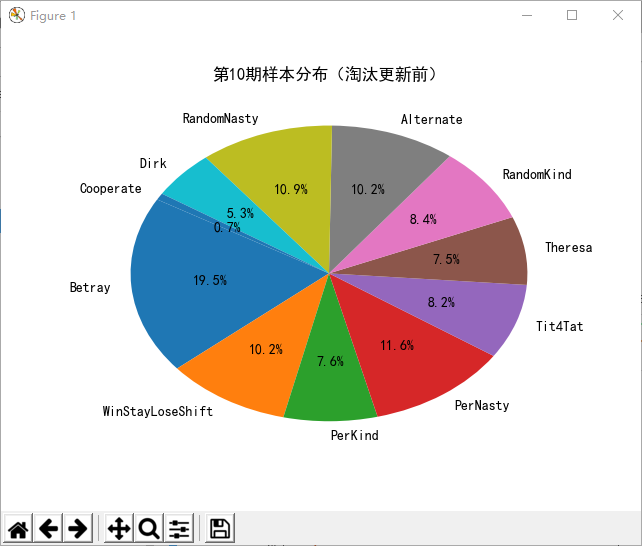

#### 2.3.2、输出沙盒最终各策略的得分平均数
传入参数为persons_score:各期策略平均分数；i:绘制期数。

In [24]:
def plot_persons_of_score(persons_score, i):
    dict = persons_score[i - 1]
    print(dict)
    dict2 = sorted(zip(dict.values(), dict.keys()), reverse=True)
#     plt.show()
    return

#### 2.3.3、绘制博弈过程不同策略样本的数量
由于每代会进行淘汰和更新，因此每代的策略样本数量都会发生变化，用折线图绘制出策略样本数量的变化

In [25]:
def plot_persons_of_counts(persons_strategy):
    labels = persons_strategy[0].keys()
    dict = {key: [] for key in labels}
    for d in persons_strategy:
        for key in d:
            dict[key].append(d[key])
    print (dict)
    names = list(range(0, len(persons_strategy)))
    x = range(len(names))
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    colorList = ["#ed1299", "#09f9f5", "#246b93", "#cc8e12", "#d561dd", "#c93f00", "#ddd53e",
                "#4aef7b", "#e86502", "#9ed84e", "#39ba30", "#6ad157", "#8249aa", "#99db27", "#e07233", "#ff523f",
                "#ce2523", "#f7aa5d", "#cebb10", "#03827f", "#931635", "#373bbf", "#a1ce4c", "#ef3bb6", "#d66551",

                 ]
    i = 0
    for key in dict:
        plt.plot(x, dict[key], c=colorList[i],  label="$"+key+"$")
        i += 1
    plt.legend(loc='center left', bbox_to_anchor=(0, 1.05), ncol=5)  # 让图例生效
    plt.xticks(x, names, rotation=1)

    plt.margins(0.01)
    plt.subplots_adjust(bottom=0.10)
    plt.xlabel('代数')  # X轴标签
    plt.ylabel("策略样本数")  # Y轴标签
    plt.show()
    return

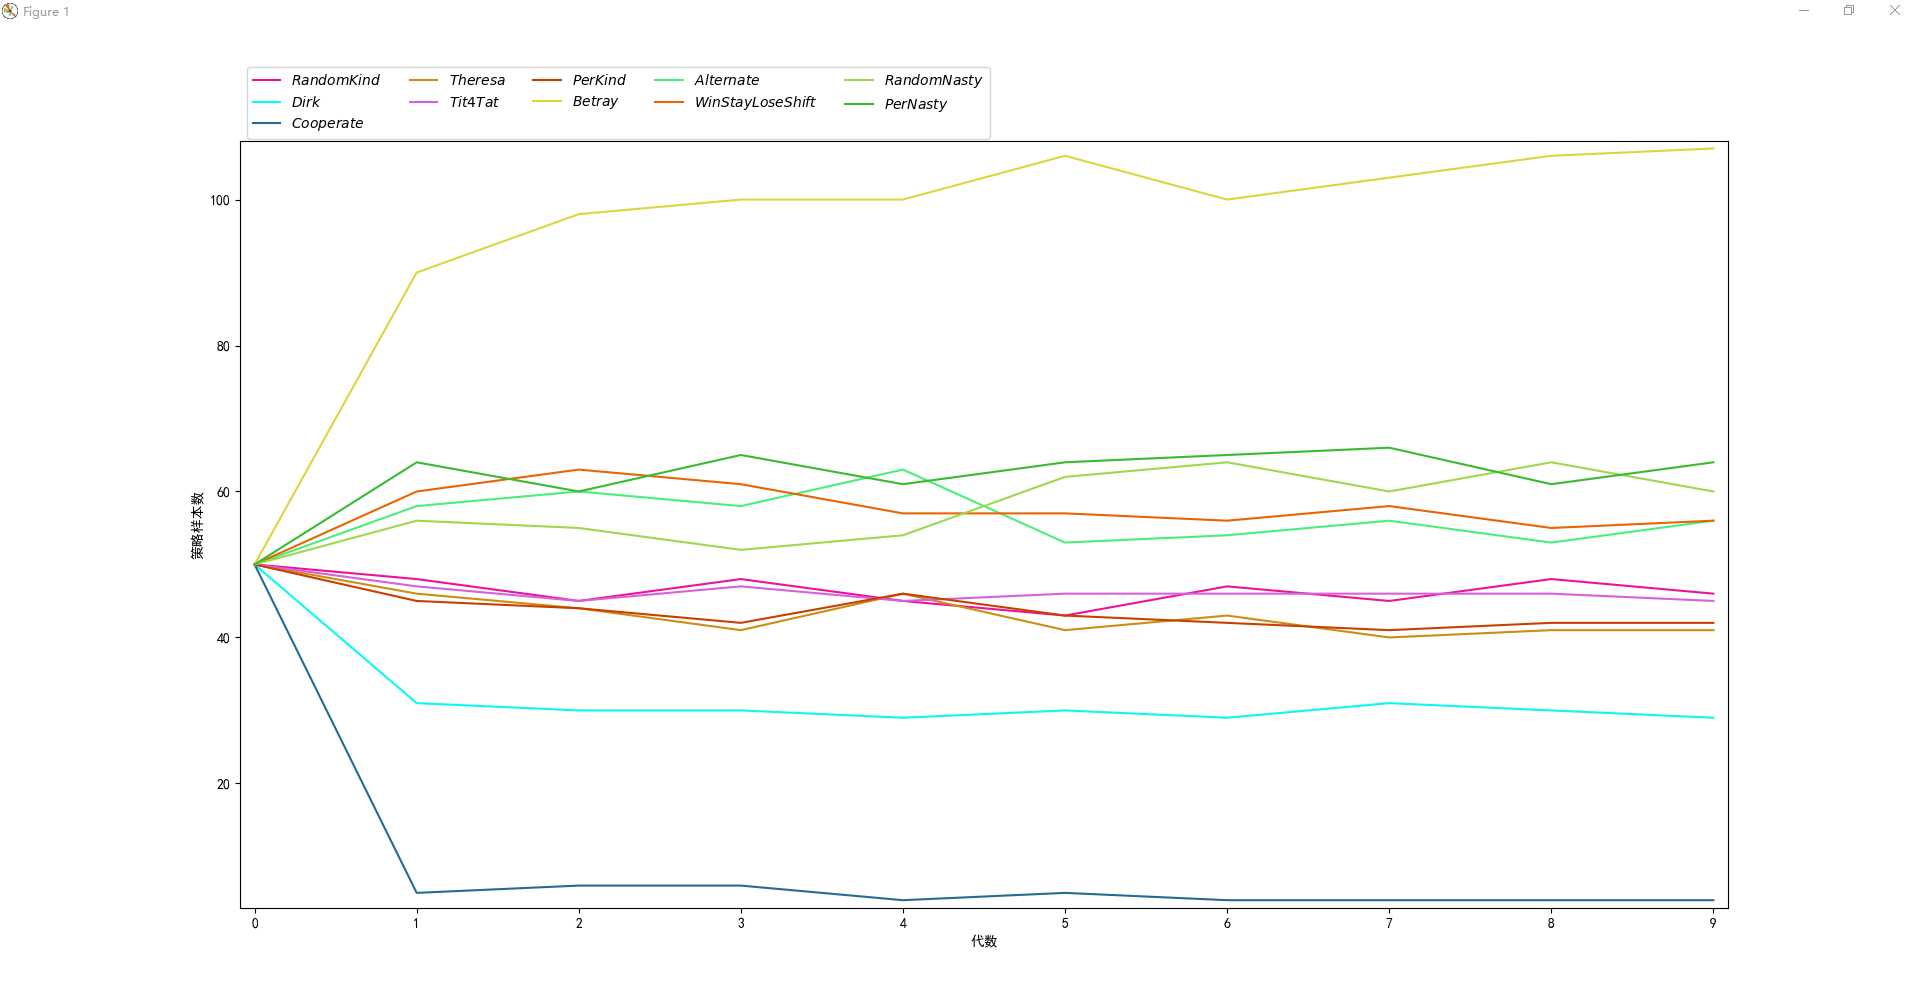

#### 2.3.4、绘制样本选择分布情况

In [26]:

def plot_persons_of_choice(persons_choice, i):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

    labels = persons_choice[i - 1].keys()
    sizes = persons_choice[i - 1].values()
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=150)
    plt.title("第" + str(i) + "代样本选择分布")
    plt.show()
    return

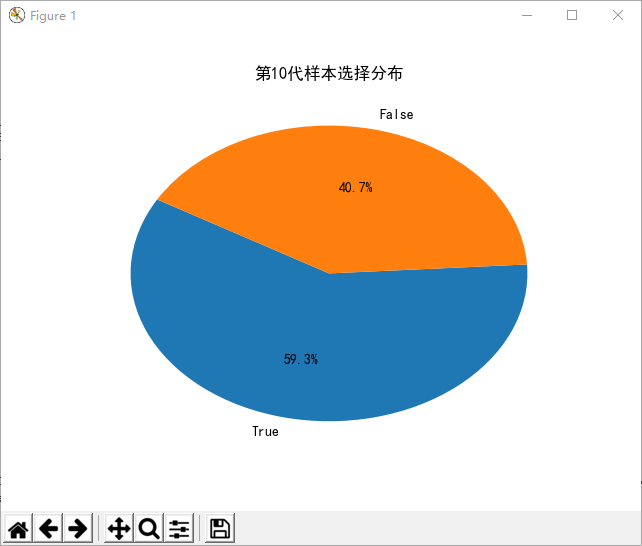

#### 2.3.5、启动沙盒博弈过程主函数

0 代, 0 期
0 代, 1 期
0 代, 2 期
0 代, 3 期
0 代, 4 期
0 代, 5 期
0 代, 6 期
0 代, 7 期
0 代, 8 期
0 代, 9 期
0 代, 10 期
0 代, 11 期
0 代, 12 期
0 代, 13 期
0 代, 14 期
0 代, 15 期
0 代, 16 期
0 代, 17 期
0 代, 18 期
0 代, 19 期
out2reinit： [Betray, Betray, Betray, Betray, Betray, Betray, Betray, WinStayLoseShift, Betray, RandomNasty, Betray, PerNasty, RandomNasty, Theresa, WinStayLoseShift, Theresa, RandomNasty, Betray, Betray, Betray, Betray, Betray, Betray, Theresa, RandomNasty, Theresa, PerKind, Betray, Betray, Theresa, PerNasty, Theresa, PerNasty, Betray, Alternate, WinStayLoseShift, Betray, Betray, RandomKind, Alternate, PerNasty, Betray, WinStayLoseShift, RandomNasty, Betray, Dirk, Theresa, Alternate, RandomNasty, Betray, WinStayLoseShift, Alternate, Alternate, RandomNasty, PerNasty, PerNasty, RandomNasty, Betray, WinStayLoseShift, RandomKind, WinStayLoseShift, RandomKind, Betray, PerNasty, WinStayLoseShift, Alternate, WinStayLoseShift, RandomNasty, RandomNasty, Alternate, PerNasty, Betray, WinStayLoseShift, Theresa,

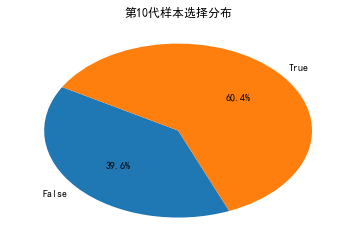

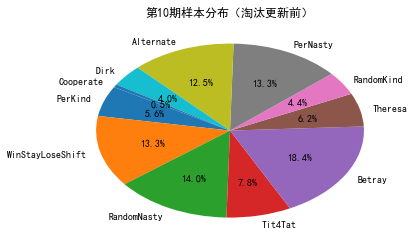

{'Tit4Tat': [50, 43, 43, 43, 44, 42, 45, 43, 43, 43], 'Theresa': [50, 50, 46, 35, 33, 33, 35, 33, 34, 34], 'WinStayLoseShift': [50, 66, 66, 71, 74, 74, 76, 74, 75, 73], 'Dirk': [50, 25, 21, 22, 22, 22, 22, 23, 26, 22], 'Alternate': [50, 74, 70, 75, 72, 73, 71, 71, 69, 69], 'PerNasty': [50, 61, 70, 71, 72, 70, 72, 70, 73, 73], 'Cooperate': [50, 2, 7, 5, 4, 3, 4, 4, 2, 3], 'PerKind': [50, 41, 32, 35, 31, 32, 29, 32, 30, 31], 'RandomNasty': [50, 62, 63, 66, 71, 71, 71, 74, 74, 77], 'RandomKind': [50, 34, 29, 28, 25, 27, 24, 25, 25, 24], 'Betray': [50, 92, 103, 99, 102, 103, 101, 101, 99, 101]}


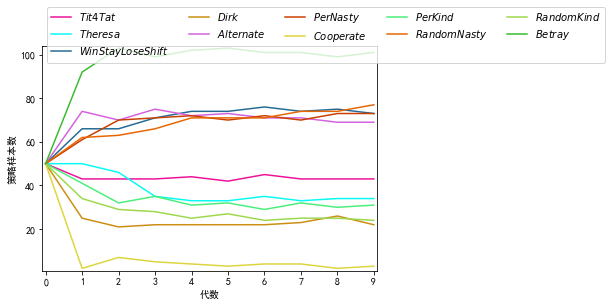

{'PerKind': 3366.2903225806454, 'WinStayLoseShift': 2416.931506849315, 'RandomNasty': 2226.0779220779223, 'Tit4Tat': 2744.860465116279, 'Betray': 2658.6138613861385, 'Theresa': 3027.323529411765, 'RandomKind': 3464.7083333333335, 'PerNasty': 2288.6849315068494, 'Alternate': 2557.6376811594205, 'Dirk': 3102.3636363636365, 'Cooperate': 1072.0}


In [27]:
if __name__ == '__main__':
#     Num_of_generation 演化代数
    Num_of_generation = 10
#     Num_of_periods 每代期数
    Num_of_periods = 20
#     Play_num_of_per_period 每期重复博弈次数
    Play_num_of_per_period = 10
#     Num_of_per_strategy 每种策略样本初始数
    Num_of_per_strategy = 50
#     Out_rate 淘汰率
    Out_rate = 0.4
#     Mutation_rate 变异率
    Mutation_rate = 0.05

#     初始化列表
    persons_strategy = []
    persons_score = []
    persons_choice = []
#     生成样本
    persons = creat_persons(Num_of_per_strategy)
#     开始博弈
    for j in range(Num_of_generation):
        for i in range(Num_of_periods):
            print (j,"代,", i,"期")
            simulate(persons, Play_num_of_per_period, seed=0)
            # for person in persons:
            #     print (person.__repr__(), "score", sum(person.get_score()), "\n", person.my_history, "\n", person.their_history)
            # break
#         计算最终策略分布
        persons_strategy.append(Counter([person.__repr__() for person in persons]))
#         计算最终策略得分均值
        strategy_name = Counter([person.__repr__() for person in persons]).keys()
        tmp = dict.fromkeys(strategy_name, 0)
        for person in persons:
            tmp[person.__repr__()] += sum(person.get_score())
        for key in tmp:
            tmp[key] = tmp[key] / persons_strategy[j][key]
        persons_score.append(tmp)
        # 计算最终样本选择分布
        choice_list = []
        for person in persons:
            choice_list += person.my_history
        persons_choice.append(Counter(choice_list))

        persons = self_reproduction(persons, Mutation_rate, Out_rate)


    plot_persons_of_choice(persons_choice, Num_of_generation)
    plot_persons_of_strategy(persons_strategy, Num_of_generation)
    plot_persons_of_counts(persons_strategy)
    plot_persons_of_score(persons_score, Num_of_generation)

## 三、结论分析

<p style="text-indent:2em">从样本选择分布可以看到，经过十轮迭代后，有超过半数的样本选择了背叛（True）；从样本分布可以看到，在众多复杂的策略中，最终没未淘汰样本最多的为背叛策略，即永远选择背叛（True）；从策略趋势图中可以看出，在众多复杂的策略中，合作策略的样本数量下降的最快，背叛策略的样本数量上升的最快，且最终背叛策略以显著的优势占据了绝大多数样本数量。该沙盒模型最终得出的结论与囚徒困境结论相同，即个人最佳选择并非团体最佳选择，随着迭代次数的增加，团体最佳的选择出现的次数会越来越多</p>